In [ ]:
# Install packages

#Install the Azure Machine Learning SDK
!pip install --upgrade azureml-sdk azureml-widgets
#Install PyCaret
!pip install pycaret==2.3.6
#Install Sequential model-based optimization in Python
!pip install scikit-optimize

**Connect to your Azure ML workspace**

All experiments and associated resources are managed within your Azure Machine Learning workspace

In [2]:
# Connection to workspaces
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

mlproject
dsproject
westeurope
d4e640c7-4b4a-44ad-81e7-1ad8cc0e8c0e


**Get Data**

Diabetes Health Indicators Dataset

Original dataset is on Kaggle:

https://www.kaggle.com/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv


Read how to Connect to data with the Azure Machine Learning studio:

https://docs.microsoft.com/en-us/azure/machine-learning/how-to-connect-data-ui?tabs=credential


In [3]:
# Get data from blob
from azureml.core import Dataset

datastore = ws.get_default_datastore()

#Data for Modeling, training and test datasets will be set in setup funciton
train_set = Dataset.Tabular.from_delimited_files(path = [(datastore, 'diabetes_train_set/03-13-2022_033336_UTC/diabetes_train_data.csv')])

#test/hold-out set or unseen data set used used to evalute the model
test_set = Dataset.Tabular.from_delimited_files(path = [(datastore, 'diabetes_train_set/03-13-2022_033336_UTC/diabetes_train_data.csv')])

# Tabular dataset to pandas dataframe
import pandas as pd

train_set = train_set.to_pandas_dataframe()
test_set = test_set.to_pandas_dataframe()

**Setting up the PyCaret environment**

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. 

setup() must be called before executing any other function in pycaret. 



In [4]:
# Setting up PyCaret environment
from pycaret.classification import *

setup_clf = setup(data = train_set
            , train_size = 0.80
            , target = 'Diabetes_binary'
            , session_id=123
            , normalize=True
            , transformation=True
            , ignore_low_variance=True
            , remove_multicollinearity=True
            , multicollinearity_threshold=0.95
            
            , preprocess = True
            , trigonometry_features=True
            , feature_selection = True
            , fold_strategy = 'kfold'
            , fold = 10
            , fold_shuffle = True
            , silent = False
            , log_experiment = True
            , experiment_name = 'Diabetes Health Indicators PyCaret Experiment')

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target,Diabetes_binary
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(152208, 22)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,18
8,Ordinal Features,False
9,High Cardinality Features,False


**Compare Models** 

Once the setup is executed, we can use compare_models to briefly evaluate the performance of all the models in the model library of PyCaret. 

This function train all the models available in the model library. The output prints a score grid with Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC (averaged accross folds), determined by fold parameter.

It can takes more than 15 minutes!

In [4]:
# Compare all models
compare_models(sort='Accuracy', cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.866,0.8267,0.1527,0.57,0.2407,0.1932,0.2448,1.359
gbc,Gradient Boosting Classifier,0.8655,0.8255,0.1594,0.56,0.248,0.1986,0.2468,8.618
lr,Logistic Regression,0.8654,0.8246,0.1607,0.5572,0.2493,0.1995,0.2469,2.324
ada,Ada Boost Classifier,0.8651,0.8243,0.1811,0.5466,0.2719,0.2178,0.2587,2.352
ridge,Ridge Classifier,0.8632,0,0.0403,0.6347,0.0758,0.0601,0.1349,0.094
lda,Linear Discriminant Analysis,0.8617,0.8189,0.2245,0.5071,0.311,0.2467,0.2723,0.591
svm,SVM - Linear Kernel,0.8608,0,0,0,0,0,0,0.375
dummy,Dummy Classifier,0.8608,0.5,0,0,0,0,0,0.043
rf,Random Forest Classifier,0.8593,0.7943,0.1515,0.4827,0.2305,0.1757,0.212,8.733
et,Extra Trees Classifier,0.8494,0.7707,0.1741,0.4043,0.2433,0.1742,0.1934,11.82


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

**Create Model**

The next step is to create a model with selected algorithm using create_model function. 

In [5]:
# Create model lightgbm
lgbm_DHI = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8677,0.8257,0.1516,0.5899,0.2412,0.1955,0.2509
1,0.8684,0.826,0.1569,0.6233,0.2507,0.2059,0.2661
2,0.863,0.8218,0.1471,0.5657,0.2335,0.1858,0.2377
3,0.8671,0.8214,0.1562,0.5418,0.2425,0.1934,0.2391
4,0.8679,0.8247,0.1545,0.5092,0.2371,0.1868,0.2272
5,0.87,0.8338,0.1526,0.5948,0.2429,0.1982,0.2543
6,0.8603,0.8211,0.1372,0.529,0.2179,0.1694,0.2169
7,0.8618,0.832,0.1627,0.5959,0.2556,0.206,0.2597
8,0.8646,0.8274,0.1589,0.5793,0.2494,0.2007,0.2524
9,0.8693,0.8325,0.1488,0.5708,0.2361,0.1906,0.2433


**Tune a Model**

When a model is created using the create_model() function it uses the default hyperparameters. In order to tune hyperparameters, the tune_model() function is used.

In [7]:
# Tuning lightgbm
tuned_lgbm_DHI = tune_model(lgbm_DHI, optimize='Accuracy', n_iter= 10
    , search_library='scikit-optimize'
    , search_algorithm='bayesian')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8661,0.8257,0.1042,0.5986,0.1775,0.1422,0.2093
1,0.8668,0.8263,0.1235,0.628,0.2065,0.1681,0.2366
2,0.8633,0.8228,0.1089,0.6006,0.1843,0.1472,0.2136
3,0.8672,0.8213,0.1128,0.5616,0.1878,0.1491,0.208
4,0.8685,0.8264,0.1125,0.5245,0.1852,0.1451,0.1976
5,0.8698,0.8362,0.1142,0.6312,0.1934,0.1581,0.2292
6,0.8605,0.8216,0.1048,0.5419,0.1756,0.1359,0.1926
7,0.8624,0.8328,0.1171,0.6582,0.1989,0.1619,0.2369
8,0.8631,0.8284,0.1131,0.5856,0.1896,0.1507,0.2136
9,0.8701,0.8307,0.1071,0.6254,0.1829,0.1491,0.2205


In [20]:
# Create Logistic Regression model
lr  = create_model('lr')  

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.865,0.8236,0.1474,0.5497,0.2325,0.1847,0.2337
1,0.8683,0.8238,0.1686,0.6102,0.2642,0.2166,0.2717
2,0.8636,0.8222,0.1592,0.5682,0.2488,0.199,0.2486
3,0.8672,0.8194,0.1719,0.5388,0.2606,0.2085,0.2502
4,0.8679,0.8226,0.17,0.5093,0.2549,0.2018,0.2389
5,0.8701,0.8333,0.1677,0.5861,0.2607,0.2129,0.2639
6,0.8594,0.8177,0.143,0.5157,0.2239,0.173,0.2168
7,0.8605,0.8293,0.1655,0.5753,0.2571,0.2053,0.2547
8,0.8651,0.8246,0.1659,0.5825,0.2582,0.2086,0.2592
9,0.8672,0.8292,0.1482,0.5396,0.2326,0.1849,0.2321


In [23]:
# Ensemble lr model
ensemble_lr = ensemble_model(lr, n_estimators = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8655,0.8236,0.1492,0.5563,0.2353,0.1876,0.2375
1,0.8681,0.8236,0.1669,0.609,0.2619,0.2146,0.2698
2,0.8633,0.8223,0.1598,0.5644,0.2491,0.199,0.2478
3,0.8669,0.8193,0.1713,0.5348,0.2595,0.2071,0.2482
4,0.868,0.8226,0.1712,0.5101,0.2564,0.2032,0.2401
5,0.8702,0.8331,0.1659,0.5885,0.2588,0.2114,0.2633
6,0.8595,0.8175,0.1448,0.5165,0.2261,0.1749,0.2185
7,0.8605,0.8293,0.1639,0.5762,0.2552,0.2037,0.2536
8,0.865,0.8246,0.163,0.583,0.2548,0.2056,0.257
9,0.8674,0.8291,0.1482,0.542,0.2328,0.1853,0.2329


In [24]:
# This function trains a Soft Voting / Majority Rule classifier for select models passed in the estimator_list parameter. 
blend = blend_models(estimator_list=[tuned_lgbm_DHI,ensemble_lr], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8661,0.826,0.1231,0.5826,0.2033,0.1628,0.2232
1,0.8679,0.8263,0.144,0.626,0.2342,0.1918,0.2554
2,0.8643,0.8238,0.1384,0.5931,0.2244,0.1804,0.2393
3,0.867,0.8215,0.1375,0.5455,0.2197,0.1744,0.225
4,0.8689,0.8258,0.1434,0.5237,0.2251,0.1782,0.2237
5,0.8707,0.8357,0.1418,0.6162,0.2306,0.1891,0.2516
6,0.8603,0.8207,0.1228,0.5327,0.1995,0.1546,0.2059
7,0.8624,0.8322,0.143,0.6225,0.2326,0.1884,0.2515
8,0.8648,0.8277,0.1375,0.5985,0.2236,0.1802,0.2403
9,0.8696,0.8311,0.1276,0.591,0.21,0.1699,0.231


**Plot a Model**

This function takes a trained model object and returns a graph based on the training/test set.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


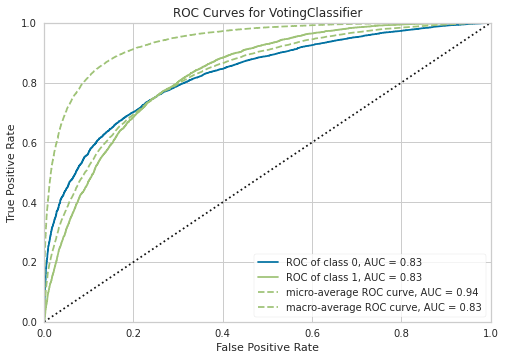

In [14]:
plot_model(blend, plot = 'auc')

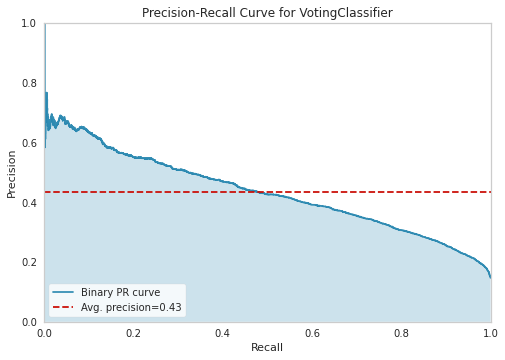

In [15]:
plot_model(blend, plot = 'pr')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


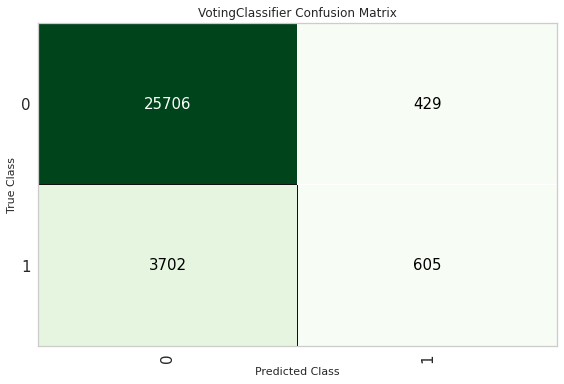

In [16]:
plot_model(blend, plot = 'confusion_matrix')

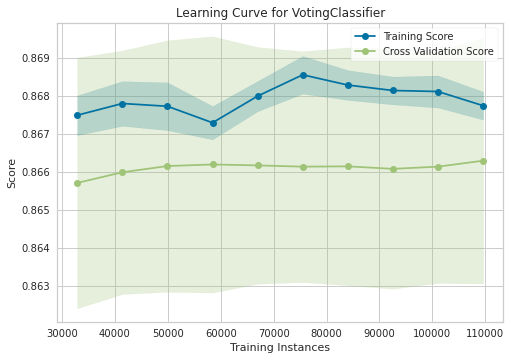

In [18]:
plot_model(blend, plot="learning")

**Predict on test / hold-out Sample**

Now, using our final trained model stored in the tuned_lightgbm variable we will predict the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [25]:
# Make predictions on the hold-out Sample

predict_model(blend)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8644,0.8294,0.1409,0.5859,0.2272,0.1824,0.2394


,Age_3,Age_8,GenHlth_1,GenHlth_4,HvyAlcoholConsump_1,Sex_1,Smoker_0,Education_6,Income_6,Age_10,...,Income_3,Income_4,Education_5,Age_2,MentHlth,Age_4,Age_13,Diabetes_binary,Label,Score
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,1.0,0.0,0,0,0.8272
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.9734
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,1.0,0,0,0.8908
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.8103
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.8948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30437,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.9815
30438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.9665
30439,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.9789
30440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,1,0,0.5441


## **Finalize Model for Deployment**

Model finalization is the last step in the experiment. 

A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. 
This workflow will eventually lead you to the best model for use in making predictions on new and unseen data. 
The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (20% in this case). 
The purpose of this function is to train the model on the complete dataset before it is deployed in production.

**What can we do after finalization?**

1. you can deploy PyCaret Model to Web Service and then, in Power BI Desktop, after signing in to your Azure account using single sign-on, you can use the service to make predicition on new unlabeled data
2. you can save .pkl model then, in Power BI Desktop, running a python script ypu can load model to make prediction on new unlabeled data

We will do it later!




In [26]:
# Finalize model
final_model = finalize_model(blend)

In [27]:
# Final Light Gradient Boosting Machine parameters for deployment
print(final_model)

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(bagging_fraction=0.8608120752388259,
                                             bagging_freq=1,
                                             boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             feature_fraction=0.4284489606984907,
                                             importance_type='split',
                                             learning_rate=0.016133245419918712,
                                             max_depth=-1, min_child_samples=95,
                                             min_child_weight=0.001,
                                             min_split_gain=0.82093142435679...
                                                                                  multi_class='auto',
                                                    

In [28]:
predict_model(final_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8662,0.8355,0.1507,0.61,0.2417,0.1966,0.2558


**Predict on unseen data**

The predict_model() function is also used to predict on the unseen dataset.

In [29]:
predict_model(final_model, data=test_set)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Label,Score
0,1,0,0,1,32,0,0,0,1,1,...,2,0,10,0,0,9,6,6,0,0.9433
1,0,1,1,1,30,1,1,0,0,0,...,3,0,0,0,0,12,5,2,0,0.6573
2,0,1,1,1,27,0,1,1,0,0,...,5,0,25,1,1,11,3,1,1,0.5749
3,0,1,0,1,30,0,0,0,1,1,...,2,0,2,0,0,10,4,5,0,0.8685
4,0,0,0,1,24,1,0,0,1,0,...,3,0,7,0,1,2,5,5,0,0.9784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152203,0,1,0,1,21,0,0,0,1,1,...,2,0,0,0,1,13,4,5,0,0.9244
152204,0,0,1,1,27,1,0,0,1,0,...,1,0,0,0,1,7,4,8,0,0.9710
152205,1,1,0,1,31,1,0,0,1,0,...,4,0,1,0,0,9,6,2,0,0.6957
152206,0,0,1,1,25,0,0,0,0,1,...,2,0,0,1,0,13,3,1,0,0.8951


**Saving the model**

In [30]:
# Save model, save pkl file local
save_model(final_model,'pycaretmodel')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Diabetes_binary',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                                                                                    n_jobs=None,
                                                                                                    penalty='l2',
        

**Save model on azure blob (deploy finalized model), and load model to get prediction**



In [31]:
# Model deploying on azure blob storage ---->>>> deploy finalized model <<<<----
from pycaret.classification import deploy_model
from pycaret.classification import load_model 

import os
connect_str = 'DefaultEndpointsProtocol=https;AccountName=mlproject2569211567;AccountKey=sBa6OSrJ8SoIchLyqjChB4YOWX7+R2z9zcynGTy6ZO9KrX4PB2jRDV+0znxUVL/tLJHA9RJM5RHgzyuyJFYUHQ==;EndpointSuffix=core.windows.net'
os.environ['AZURE_STORAGE_CONNECTION_STRING'] = connect_str

from pycaret.classification import load_model
deploy_model(model = final_model, model_name = 'pycaretmodel', platform = 'azure', authentication = {'container' : 'models'})

Model Successfully Deployed on Azure Storage Blob


In [32]:
# Load model to get prediction on new data
import os
os.environ['AZURE_STORAGE_CONNECTION_STRING'] = connect_str

from pycaret.classification import load_model
loaded_model = load_model(model_name = 'pycaretmodel', platform = 'azure', authentication = {'container' : 'models'})

Transformation Pipeline and Model Successfully Loaded


In [33]:
from pycaret.classification import predict_model
predictions = predict_model(loaded_model, data = test_set)
predict_model(loaded_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8662,0.8355,0.1507,0.61,0.2417,0.1966,0.2558


,Age_3,Age_8,GenHlth_1,GenHlth_4,HvyAlcoholConsump_1,Sex_1,Smoker_0,Education_6,Income_6,Age_10,...,Income_3,Income_4,Education_5,Age_2,MentHlth,Age_4,Age_13,Diabetes_binary,Label,Score
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,1.0,0.0,0,0,0.8231
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.9730
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,1.0,0,0,0.8937
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.8167
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.8924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30437,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.9816
30438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.9661
30439,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,0,0,0.9798
30440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.627261,0.0,0.0,1,0,0.5431


**Deploy on Azure as Web Service**

In [34]:
# Model registration on azure ml studio
import sklearn

from azureml.core import Workspace
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration

ws = Workspace.from_config()

model = Model.register(workspace=ws,
                       model_name='pycaretmodel',                               # Name of the registered model in your workspace.
                       model_path='pycaretmodel.pkl',                           # Local file to upload and register as a model.
                       model_framework=Model.Framework.SCIKITLEARN,     # Framework used to create the model.
                       model_framework_version=sklearn.__version__,     # Version of scikit-learn used to create the model.
                       #sample_input_dataset=X_train,
                       #sample_output_dataset=y_train,
                       #description='Decision tree model to predict diabetes progression.',
                       tags={'area': 'classification', 'type': 'classification'}
                       )

print('Name:', model.name)
print('Version:', model.version)

Registering model pycaretmodel
Name: pycaretmodel
Version: 1


In [45]:
%%writefile pycaretmodel.py

# Create scoring srcript

import json
import pickle
import numpy as np
import pandas as pd
import os
import joblib
from azureml.core.model import Model

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType
from inference_schema.parameter_types.standard_py_parameter_type import StandardPythonParameterType


def init():
    global model
    # Replace filename if needed.
    path = os.getenv('AZUREML_MODEL_DIR') 
    model_path = os.path.join(path, 'pycaretmodel.pkl')
    # Deserialize the model file back into a sklearn model.
    model = joblib.load(model_path)


input_sample =pd.DataFrame({"HighBP": pd.Series([0], dtype="int64"), "HighChol": pd.Series([0], dtype="int64")
, "CholCheck": pd.Series([0], dtype="int64"), "BMI": pd.Series([0], dtype="int64"), "Smoker": pd.Series([0], dtype="int64")
, "Stroke": pd.Series([0], dtype="int64"), "HeartDiseaseorAttack": pd.Series([0], dtype="int64")
, "PhysActivity": pd.Series([0], dtype="int64"), "Fruits": pd.Series([0], dtype="int64"), "Veggies": pd.Series([0], dtype="int64"), "HvyAlcoholConsump": pd.Series([0], dtype="int64"), "AnyHealthcare": pd.Series([0], dtype="int64"), "NoDocbcCost": pd.Series([0], dtype="int64"), "GenHlth": pd.Series([0], dtype="int64"), "MentHlth": pd.Series([0], dtype="int64"), "PhysHlth": pd.Series([0], dtype="int64"), "DiffWalk": pd.Series([0], dtype="int64"), "Sex": pd.Series([0], dtype="int64")
, "Age": pd.Series([0], dtype="int64"), "Education": pd.Series([0], dtype="int64"), "Income": pd.Series([0], dtype="int64")}) 


# This is an integer type sample. Use the data type that reflects the expected result.
output_sample = np.array([0])

# To indicate that we support a variable length of data input,
# set enforce_shape=False
@input_schema('data', PandasParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))
def run(data):
    try:
        print("input_data....")
        print(data.columns)
        print(type(data))
        result = model.predict(data)
        print("result.....")
        print(result)
    # You can return any data type, as long as it can be serialized by JSON.
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Overwriting pycaretmodel.py


In [46]:
# Create environment configuration for inference

from azureml.core.model import InferenceConfig
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

environment = Environment('my-env')
environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'pandas',
    'pycaret',
    'scikit-learn=={}'.format(sklearn.__version__)
])

inference_config = InferenceConfig(entry_script='./pycaretmodel.py',environment=environment)

In [47]:
# Model deploying on azure

from pycaret.classification import deploy_model
from pycaret.classification import load_model 

service_name = 'pycaretmodel'

service = Model.deploy(ws, service_name, [model], inference_config, overwrite=True)
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-03-13 21:48:46+00:00 Creating Container Registry if not exists.
2022-03-13 21:48:46+00:00 Registering the environment.
2022-03-13 21:48:48+00:00 Use the existing image.
2022-03-13 21:48:48+00:00 Generating deployment configuration.
2022-03-13 21:48:49+00:00 Submitting deployment to compute.
2022-03-13 21:48:52+00:00 Checking the status of deployment pycaretmodel..
2022-03-13 21:49:12+00:00 Checking the status of inference endpoint pycaretmodel.
Succeeded
ACI service creation operation finished, operation "Succeeded"
